# Self-Driving Car Engineer Nanodegree


## Deep Learning

## Project: Traffic Sign Recognition Classifier 

by **Vikas Hanasoge Nataraja**



---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle
import pandas as pd
import sklearn
import numpy as np
# TODO: Fill this in based on where you saved the training and testing data

training_file = "pickles/train.p"
validation_file= "pickles/valid.p"
testing_file = "pickles/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 


### Basic Summary of the Dataset 

In [3]:
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(ar=y_train).shape[0]

image_depth_dimension = X_train.shape[3]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43




#### So, what do the images in the dataset look like? 

The images are 32x32x3, meaning they are very low resolution color images.
Below, I am showing how the images look like, chosen at random.

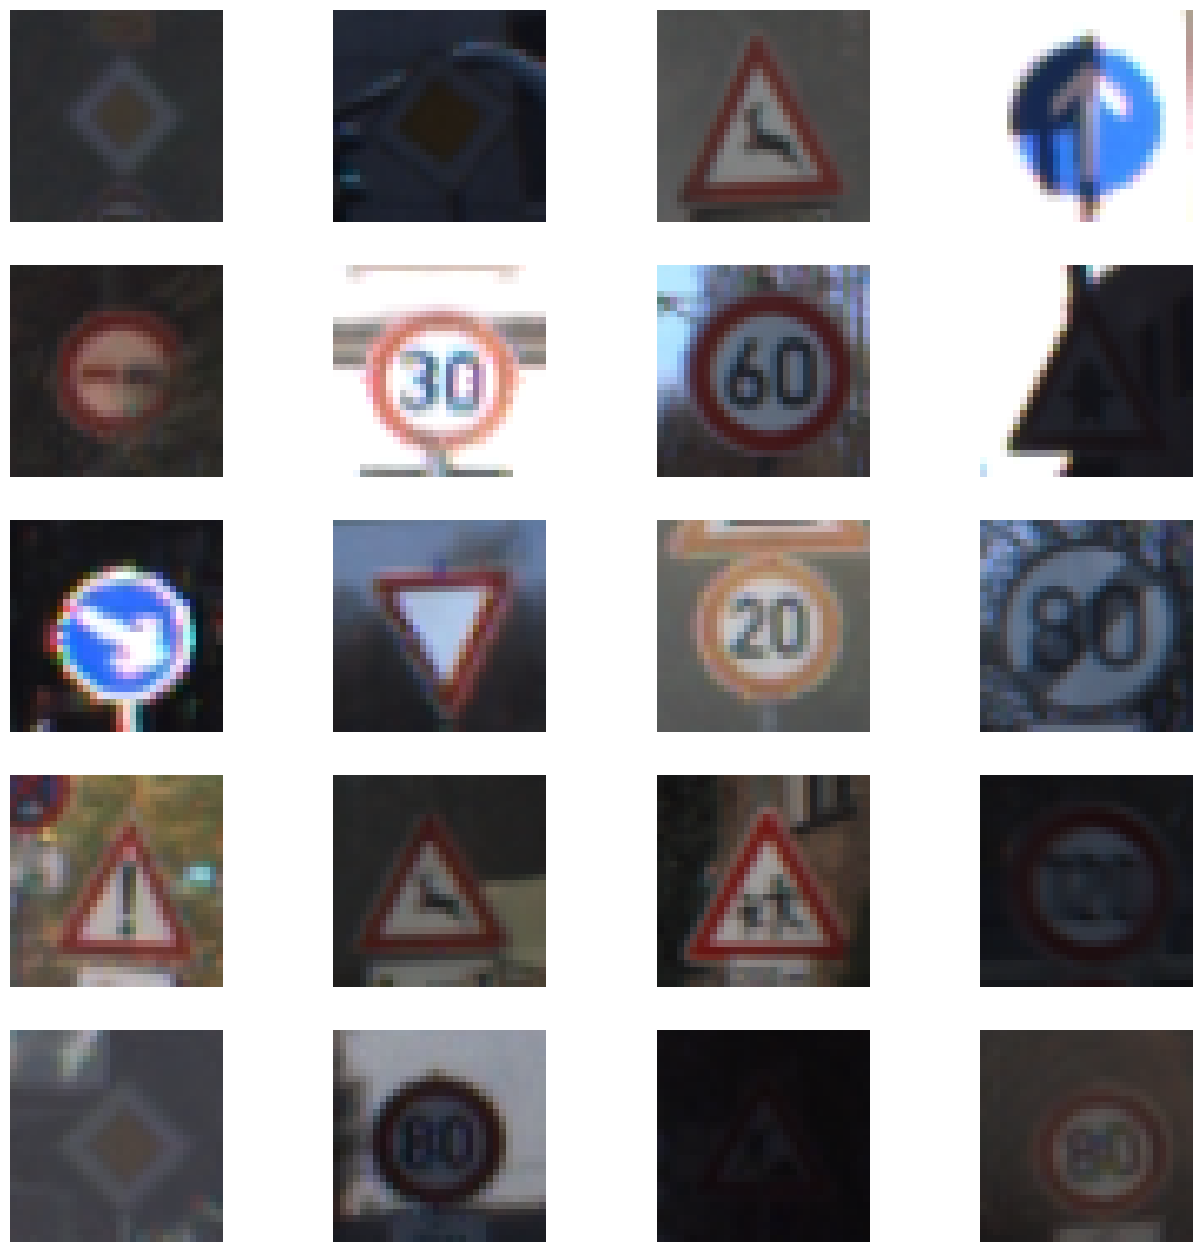

In [5]:

import matplotlib.pyplot as plt
from random import randint
# Visualizations will be shown in the notebook.
%matplotlib inline
fig=plt.figure(figsize=(16, 16))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # show random images from the dataset
    img = X_train[randint(0, n_train-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')   
plt.show()


----

## Step 2: Design and Test a Model Architecture

In this step, I am designing and implementing a deep learning model that learns to recognize traffic signs. Training and testing the model is done using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

LeNet-5, a type of CNN, is being used here. LeNet is a deep-learning model developed by Yann LeCun, more information can be found [here](http://yann.lecun.com/exdb/lenet/).


There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).


Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Here, I am using a simple normalization technique - (x-min)/(max-min) for all the pixels in the image.

What this does is essentially normalizes the pixel values to between 0 and 1, thereby chaning contrast. Images before and after normalization are shown below.

In [6]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [length, width, color_depth]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [7]:
normalized_train = np.zeros([n_train,32,32,3])
normalized_validation = np.zeros([n_validation,32,32,3])
normalized_test = np.zeros([n_test,32,32,3])
for i in range(0,n_train):
    normalized_train[i] = normalize(X_train[i])
for i in range(0,n_validation):
    normalized_validation[i] = normalize(X_valid[i])
for i in range(0,n_test):
    normalized_test[i] = normalize(X_test[i])

assert(X_train.shape==normalized_train.shape)

### Show the difference normalization makes

Text(0.5, 1.0, 'Normalized Image')

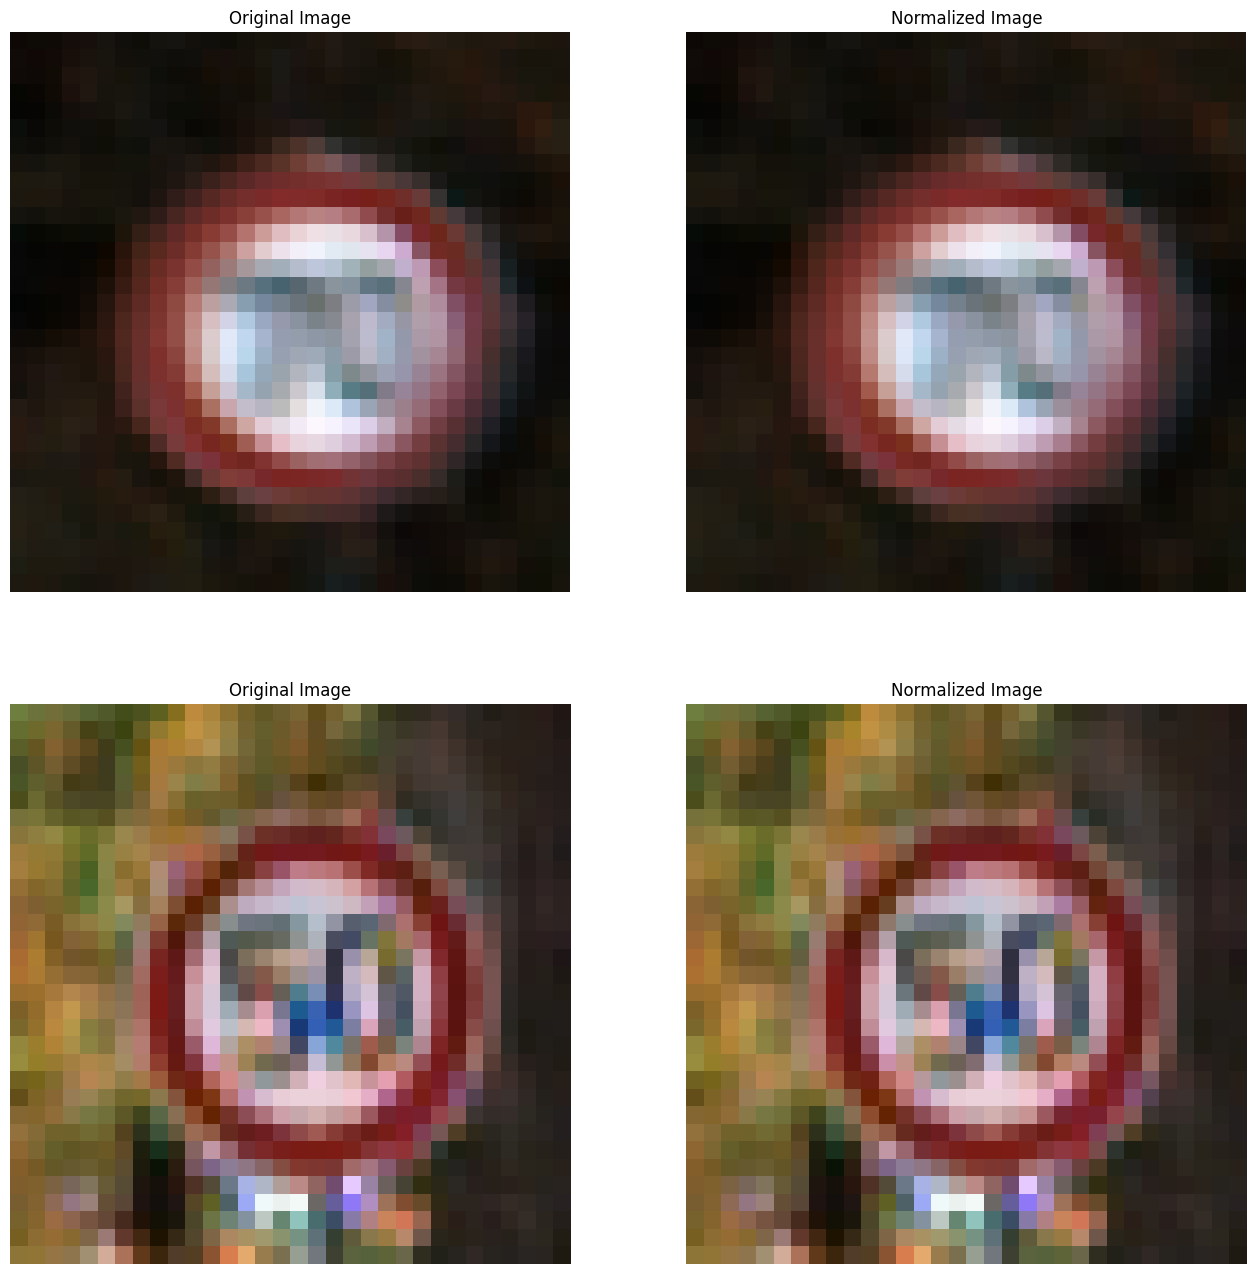

In [21]:
f, axarr = plt.subplots(nrows=2,ncols=2,figsize = (16,16))
randomindex = randint(0,n_train-1)
axarr[0,0].imshow(X_train[randomindex])
axarr[0,0].axis('off')
axarr[0,0].set_title('Original Image')
axarr[0,1].imshow(normalized_train[randomindex])
axarr[0,1].axis('off')
axarr[0,1].set_title('Normalized Image')
randomindex = randint(0,n_train-1)
axarr[1,0].imshow(X_train[randomindex])
axarr[1,0].axis('off')
axarr[1,0].set_title('Original Image')
axarr[1,1].imshow(normalized_train[randomindex])
axarr[1,1].axis('off')
axarr[1,1].set_title('Normalized Image')

### Make the normalized dataset the set to be used in the model

In [9]:
X_train = normalized_train

X_valid = normalized_validation

X_test = normalized_test

### Model Architecture

In [11]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# convolution function (defining now with Wx + b, so I can use conv layers multiple times)
def convolve(X, W, b, strides=1):
    X = tf.nn.conv2d(X, W, strides=[1, strides, strides, 1], padding='VALID')
    X = tf.nn.bias_add(X, b)
    print('Shape of X after bias, before activation is',X.shape,'\n')
    return tf.nn.relu(X)

# start LeNet 
def LeNet(X):
    # mean = 0, std. deviation = 0.1
    mu = 0
    sigma = 0.1
    
    W_1 = tf.Variable(tf.truncated_normal(shape=(5, 5, image_depth_dimension, 6), mean = mu, stddev = sigma))
    b_1 = tf.Variable(tf.zeros(6))
    # perform convolution
    layer_1 = convolve(X, W_1, b_1, 1)
    
    layer_1 = tf.nn.max_pool(layer_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print('Shape of layer 1:',layer_1.shape,'\n')

    
    W_2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    b_2 = tf.Variable(tf.zeros(16))
    layer_2 = convolve(layer_1, W_2, b_2, 1)

    layer_2 = tf.nn.max_pool(layer_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print('Shape of layer 2:',layer_2.shape,'\n')
    
    
    W_2_1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 412), mean = mu, stddev = sigma))
    b_2_1 = tf.Variable(tf.zeros(412))
    layer_2_1 = convolve(layer_2, W_2_1, b_2_1, 1)

    
    print('Shape of layer 2.1 =',layer_2_1.shape,'\n')
  
    
    flat = flatten(layer_2_1)

    W_3 = tf.Variable(tf.truncated_normal(shape=(412, 122), mean = mu, stddev = sigma))
    b_3 = tf.Variable(tf.zeros(122))
    layer_3 = tf.nn.relu(tf.nn.bias_add(tf.matmul(flat, W_3), b_3))
    layer_3 = tf.nn.dropout(layer_3, keep_prob)
    
    W_4 = tf.Variable(tf.truncated_normal(shape=(122, 84), mean = mu, stddev = sigma))
    b_4 = tf.Variable(tf.zeros(84))
    layer_4 = tf.nn.relu(tf.nn.bias_add(tf.matmul(layer_3, W_4), b_4))
    layer_4 = tf.nn.dropout(layer_4, keep_prob)
    
    W_5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b_5 = tf.Variable(tf.zeros(43))
    layer_5 = tf.nn.bias_add(tf.matmul(layer_4, W_5), b_5)
    
    return layer_5

x = tf.placeholder(tf.float32, (None, 32, 32, image_depth_dimension))
y = tf.placeholder(tf.int32, (None))
one_hot_y_labels = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

2024-07-21 19:00:31.397552: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 19:00:31.408463: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-21 19:00:31.433244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 19:00:31.451745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 19:00:31.456112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 19:00:31.466232: I tensorflow/core/platform/cpu_feature_gu

ModuleNotFoundError: No module named 'tensorflow.contrib'

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [20]:
epochs = 25
batch_size = 156

learn_rate = 0.004

logits = LeNet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y_labels)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y_labels, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    n_examples = len(X_data)
    final_accuracy = 0
    sess = tf.get_default_session()
    for i in range(0, n_examples, batch_size):
        batch_x, batch_y = X_data[i:i+batch_size], y_data[i:i+batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        final_accuracy += (accuracy * len(batch_x))
    
    return final_accuracy/n_examples

Shape of X after bias, before activation is (?, 28, 28, 6) 

Shape of layer 1: (?, 14, 14, 6) 

Shape of X after bias, before activation is (?, 10, 10, 16) 

Shape of layer 2: (?, 5, 5, 16) 

Shape of X after bias, before activation is (?, 1, 1, 412) 

Shape of layer 2.1 = (?, 1, 1, 412) 



In [21]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    n_examples = len(X_train)
    
    print("Training LeNet on dataset, please wait\n")
    
    train_accuracy_list = []
    validation_accuracy_list = []
    
    for i in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for ii in range(0, n_examples, batch_size):
            
            batch_x, batch_y = X_train[ii:ii+batch_size], y_train[ii:ii+batch_size]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
            
        train_accuracy = evaluate(X_train,y_train)
        train_accuracy_list.append(train_accuracy)
        
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_list.append(validation_accuracy)
        
      
        print('Epoch {} ...'.format(i+1))
        print('Training Accuracy = {:.3f}'.format(train_accuracy))
        print('Validation Accuracy = {:.3f}'.format(validation_accuracy))
        print('----------------------------')
        
        
    saver.save(sess, './lenet')
    print("Training completed, model saved")

Training LeNet on dataset, please wait

Epoch 1 ...
Training Accuracy = 0.899
Validation Accuracy = 0.827
----------------------------
Epoch 2 ...
Training Accuracy = 0.975
Validation Accuracy = 0.916
----------------------------
Epoch 3 ...
Training Accuracy = 0.984
Validation Accuracy = 0.914
----------------------------
Epoch 4 ...
Training Accuracy = 0.982
Validation Accuracy = 0.926
----------------------------
Epoch 5 ...
Training Accuracy = 0.993
Validation Accuracy = 0.934
----------------------------
Epoch 6 ...
Training Accuracy = 0.994
Validation Accuracy = 0.926
----------------------------
Epoch 7 ...
Training Accuracy = 0.993
Validation Accuracy = 0.930
----------------------------
Epoch 8 ...
Training Accuracy = 0.975
Validation Accuracy = 0.907
----------------------------
Epoch 9 ...
Training Accuracy = 0.992
Validation Accuracy = 0.941
----------------------------
Epoch 10 ...
Training Accuracy = 0.992
Validation Accuracy = 0.934
----------------------------
Epoch 11 

### Plot the accuracies, make sense of them

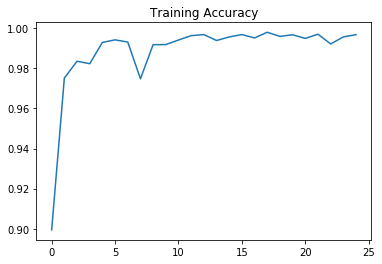

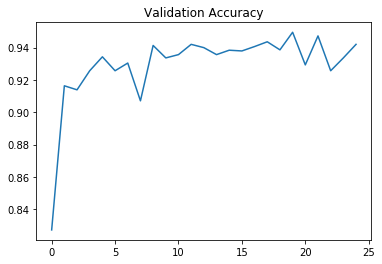

In [22]:
plt.plot(train_accuracy_list)
plt.title("Training Accuracy")
plt.show()

plt.plot(validation_accuracy_list)
plt.title("Validation Accuracy")
plt.show()

In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train, y_train)
    print("Training Accuracy = {:.3f}".format(train_accuracy))
    
    valid_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(valid_accuracy))    
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Training Accuracy = 0.997
Validation Accuracy = 0.942
Test Accuracy = 0.927


---

## Step 3: Test a Model on New Images

To provide more insight into how the model is working, I downloaded 6 pictures of German traffic signs from the web and used the model to predict the traffic sign type.

The `signnames.csv` is useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

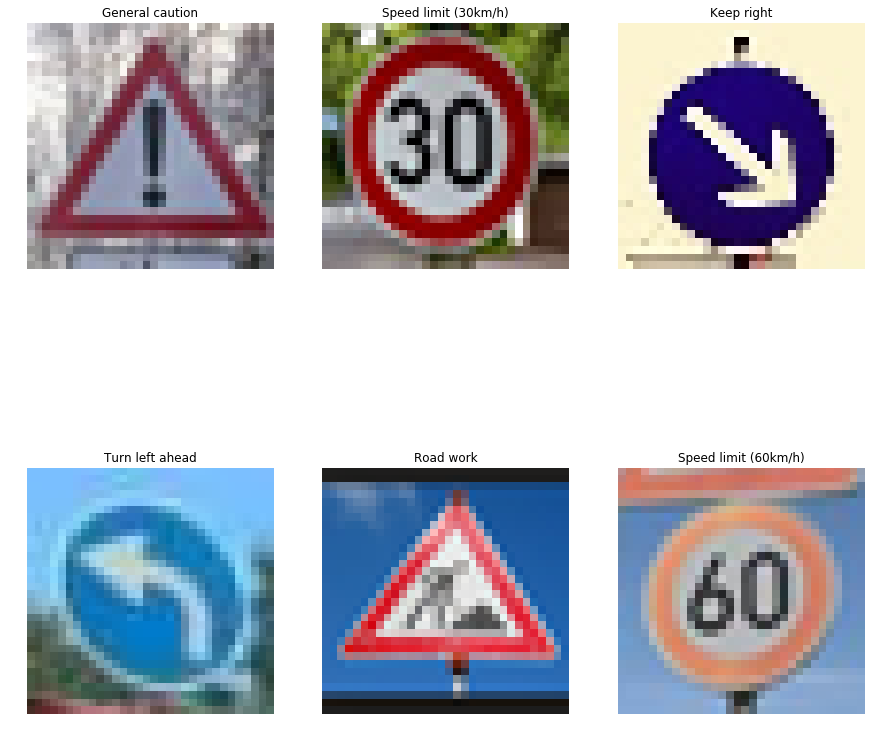

In [24]:
### Load the images and plot them here.


import glob
import cv2

my_images = sorted(glob.glob('./mysigns/*.png'))

my_labels = np.array([18, 1, 38, 34, 25, 3])

figures = {}
labels = {}
my_signs = []
index = 0
name_values = np.genfromtxt('signnames.csv', 
                            skip_header=1, dtype=[('myint','i8'), ('mystring','S55')],
                            delimiter=',')
#print(name_values)
for my_image in my_images:
    
    img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    my_signs.append(img)
    figures[index] = img
    labels[index] = name_values[my_labels[index]][1].decode('ascii')
    index += 1

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))
i=0
j=0
for idx in range(len(figures)):
    
    ax[i,j].imshow(figures[idx])
    ax[i,j].axis('off')
    ax[i,j].set_title(labels[idx])
    j+=1
    if j==3:
        j=0
        i=1

### Normalize the images from the web

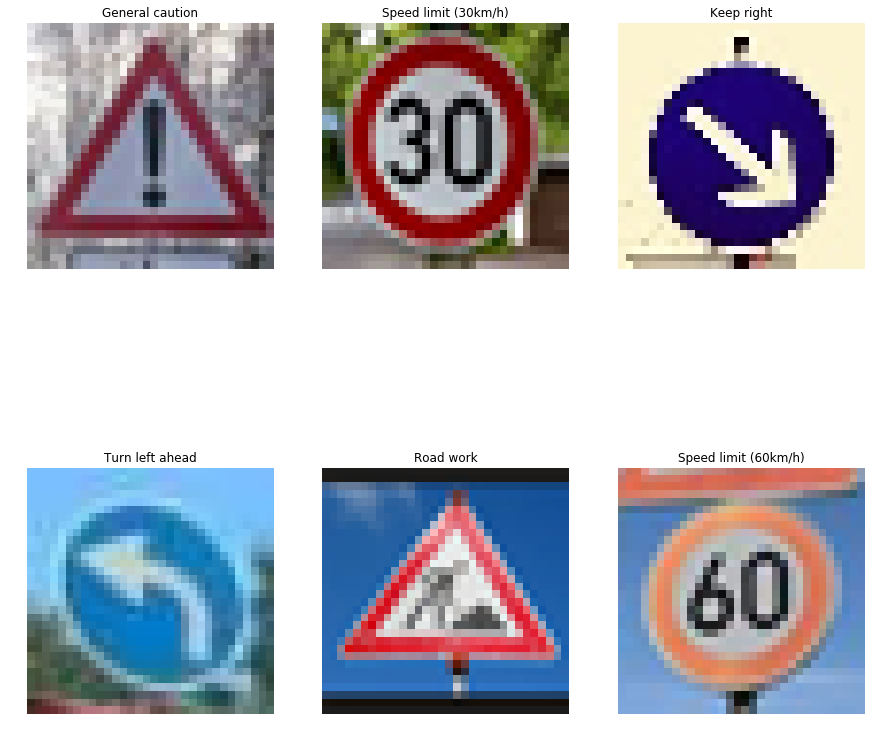

In [25]:
my_signs = np.array(my_signs)
my_signs_norm=[]
for i in range(len(my_signs)):
    my_signs_norm.append(normalize(my_signs[i]))

fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(15,15))
i=0
j=0
for idx in range(len(my_signs_norm)):
    
    ax[i,j].imshow(my_signs_norm[idx])
    ax[i,j].axis('off')
    ax[i,j].set_title(labels[idx])
    j+=1
    if j==3:
        j=0
        i=1

#### Convert to array

In [26]:
my_signs_normalized = np.asarray(my_signs_norm)
print(my_signs_normalized)

array([18,  1, 38, 34, 25,  3])

### Predict the Sign Type for Each Image

In [27]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver.restore(sess, "./lenet")
    
        
    my_accuracy = evaluate(my_signs_normalized, my_labels)
    print("My Data Set Accuracy = {:.3f}".format(my_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
My Data Set Accuracy = 1.000


### Analyze Performance

In [28]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
test_signs = []
test_signs_label = []

for i in range(6):
    test_signs.append(my_signs_normalized[i])
    test_signs_label.append(my_labels[i])

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, "./lenet")
        test_image_accuracy = evaluate(test_signs, test_signs_label)
        print('Image {}'.format(i+1))
        print("Image Accuracy = {:.3f}".format(test_image_accuracy*100),"%")
        


INFO:tensorflow:Restoring parameters from ./lenet
Image 1
Image Accuracy = 100.000 %
INFO:tensorflow:Restoring parameters from ./lenet
Image 2
Image Accuracy = 100.000 %
INFO:tensorflow:Restoring parameters from ./lenet
Image 3
Image Accuracy = 100.000 %
INFO:tensorflow:Restoring parameters from ./lenet
Image 4
Image Accuracy = 100.000 %
INFO:tensorflow:Restoring parameters from ./lenet
Image 5
Image Accuracy = 100.000 %
INFO:tensorflow:Restoring parameters from ./lenet
Image 6
Image Accuracy = 100.000 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, we can confirm these are the 3 largest probabilities in `a`. Also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet


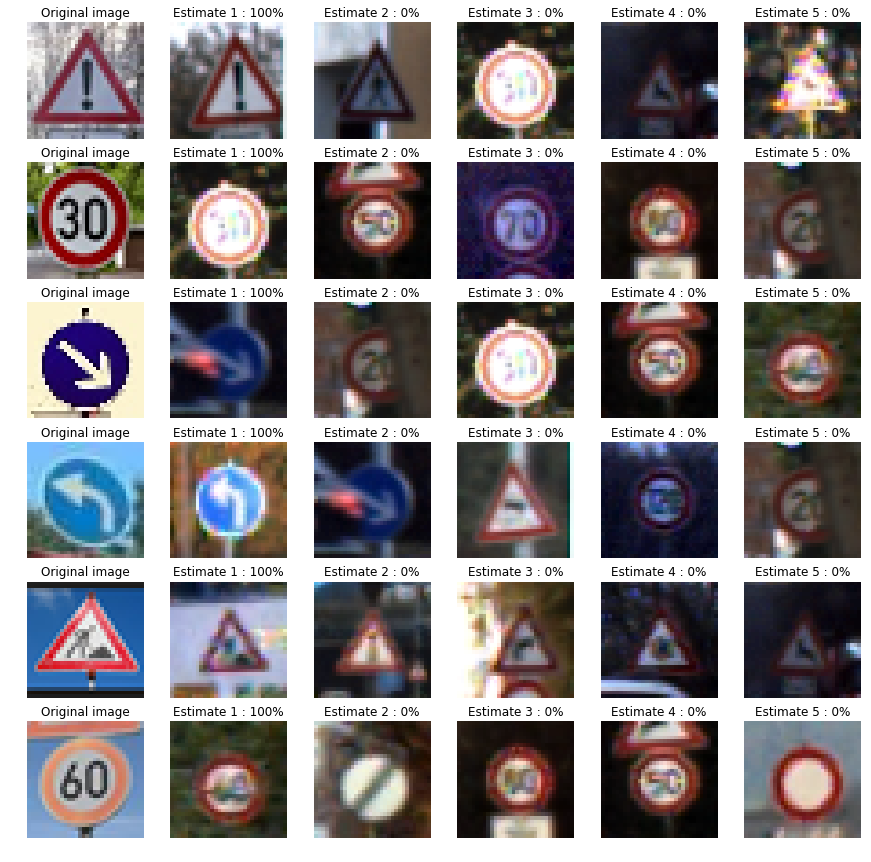

In [65]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

k = 5 # number of probabilities for class
softmax_operation = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_operation, k=k)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_operation, feed_dict={x: my_signs_normalized, keep_prob: 1.0})
    my_signs_top_k = sess.run(top_k, feed_dict={x: my_signs_normalized, keep_prob: 1.0})
    fig,ax = plt.subplots(ncols=6,nrows=6,figsize=(15,15))
    for i in range(len(my_signs)):
        test_im = {}
        test_im_labels = {}
        
        test_im[0] = my_signs[i]
        test_im_labels[0] = 'Original image'
        
        for j in range(k):
            test_im[j+1] = X_valid[np.argwhere(y_valid == my_signs_top_k[1][i][j])[0]].squeeze()
            test_im_labels[j+1] = 'Estimate {} : {:.0f}%'.format(j+1, 100*my_signs_top_k[0][i][j])
            
            #plt.figure()
            ax[i,0].imshow(test_im[0])
            ax[i,0].set_title(test_im_labels[0])
            ax[i,0].axis('off')
            ax[i,j+1].imshow(test_im[j+1])
            ax[i,j+1].set_title(test_im_labels[j+1])
            ax[i,j+1].axis('off')
    